C:\Users\LENOVO\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


11490434/11490434 [==============================] - 3s 0us/step


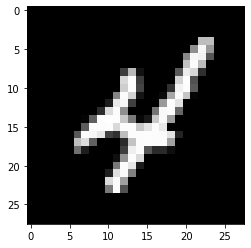

In [1]:
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Plot the sample output of the image
plt.imshow(X_train[9], cmap=plt.get_cmap('gray'))
plt.show()

In [4]:
pip install tensorflow keras pillow numpy tqdm jupyterlab


Note: you may need to restart the kernel to use updated packages.


In [9]:
#Required package for the image caption generator 
import numpy as np
from PIL import Image
import os
import string
from pickle import dump, load
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tqdm.notebook import tqdm


In [10]:
import os
import string

# Load the document file into memory
def load_fp(filename):
    # Open file to read
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption_text = caption.split('\t')
        img_id = img.split('#')[0]  # Get the image id without the "#0" or similar part
        if img_id not in descriptions:
            descriptions[img_id] = [caption_text]
        else:
            descriptions[img_id].append(caption_text)
    return descriptions

# Data cleaning function will convert all uppercase alphabets to lowercase, remove punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # Remove hanging 's and 'a
            descp = [wrd for wrd in descp if len(wrd) > 1]
            # Remove words containing numbers
            descp = [wrd for wrd in descp if wrd.isalpha()]
            # Converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

# To build vocab of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

# Set these paths according to your project folder
dataset_text = "C:/Users/LENOVO/Downloads/Flickr8k_text (1)"
dataset_images = "C:/Users/LENOVO/Downloads/Flickr8k_Dataset (1)/Flicker8k_Dataset"

# Prepare our text data
filename = os.path.join(dataset_text, "Flickr8k.token.txt")

# Loading the file that contains all data and mapping them into descriptions dictionary
descriptions = img_capt(filename)
print("Length of descriptions =", len(descriptions))

# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# Build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")


Length of descriptions = 8092
Length of vocabulary = 8422


In [12]:
model = Xception(include_top=False, pooling='avg')


83683744/83683744 [==============================] - 10s 0us/step


In [14]:
import os
import numpy as np
from tqdm.notebook import tqdm
from keras.applications.xception import Xception
from PIL import Image
from pickle import dump, load

def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for pic in tqdm(os.listdir(directory)):
        file = os.path.join(directory, pic)
        image = Image.open(file)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        # image = preprocess_input(image)
        image = image / 127.5
        image = image - 1.0
        feature = model.predict(image)
        img_id = os.path.splitext(pic)[0]  # Extract image ID from the filename
        features[img_id] = feature
    return features

# Extracting features
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

# Loading features from the pickle file
features = load(open("features.p", "rb"))


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 472ms/step


In [30]:
from keras.preprocessing.text import Tokenizer
from pickle import dump, load
import numpy as np

# Function to convert descriptions dictionary to a list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        all_desc.extend(descriptions[key])
    return all_desc

# Function to create a tokenizer and fit it on the descriptions
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# Create and save the tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Function to calculate the maximum length of descriptions
def calculate_max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

# Calculate and print maximum length
max_length_value = calculate_max_length(train_descriptions)
print(f"Max length of descriptions: {max_length_value}")


Vocabulary size: 7318
Max length of descriptions: 33


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

# Data generator function used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            if key not in features:
                continue  # Skip if the feature for the key is missing
            # Retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

# Function to create sequences for training
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # Move through each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # Divide one sequence into various X, y pairs
        for i in range(1, len(seq)):
            # Divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)

# To check the shape of the input and output for your model
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))
print(a.shape, b.shape, c.shape)  # Expected output: ((47, 2048), (47, 32), (47, 7577))



In [ ]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.models import Model
from keras.utils import plot_model

# Define the captioning model
def define_model(vocab_size, max_length):
    # Features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [ ]:
import os
from keras.models import Model

# Print dataset statistics
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# Define and compile the model
model = define_model(vocab_size, max_length)

# Training parameters
epochs = 10
steps_per_epoch = len(train_descriptions) // 32  # Adjust batch size as needed

# Create directory to save models
os.makedirs("models", exist_ok=True)

# Train the model
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)
    model.save(f"models/model_{i}.h5")


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.applications.xception import Xception, preprocess_input
from pickle import load

# Argument parser
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True, help="Image Path")
args = vars(ap.parse_args())
img_path = args['image']

# Function to extract features from an image
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print(f"ERROR: Can't open image! Ensure that image path and extension is correct. {e}")
        return None
    
    image = image.resize((299, 299))
    image = np.array(image)
    
    # Convert 4 channels to 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Use preprocess_input from Xception for correct preprocessing
    feature = model.predict(image)
    return feature

# Function to get the word for an integer ID
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate description for the image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Main script
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

# Extract features and generate description
photo = extract_features(img_path, xception_model)
if photo is not None:
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\nDescription:")
    print(description)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.applications.xception import Xception, preprocess_input
from pickle import load

# Argument parser
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True, help="Image Path")
args = vars(ap.parse_args())
img_path = args['image']

# Function to extract features from an image
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print(f"ERROR: Can't open image! Ensure that image path and extension is correct. {e}")
        return None
    
    image = image.resize((299, 299))
    image = np.array(image)
    
    # Convert 4 channels to 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Use preprocess_input from Xception for correct preprocessing
    feature = model.predict(image)
    return feature

# Function to get the word for an integer ID
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate description for the image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            print(f"No word found for index {pred}")
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Main script
max_length = 32

# Load tokenizer and model
try:
    tokenizer = load(open("tokenizer.p", "rb"))
    model = load_model('models/model_9.h5')
except Exception as e:
    print(f"Error loading tokenizer or model: {e}")
    exit()

# Initialize Xception model
xception_model = Xception(include_top=False, pooling="avg")

# Extract features and generate description
photo = extract_features(img_path, xception_model)
if photo is not None:
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\nDescription:")
    print(description)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("Failed to extract features from the image.")
